In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [2]:
from pathlib import Path
import requests

In [3]:
csvpath = Path("HON_nasdaqdata.csv")

In [4]:
df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [5]:
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-07-06,$218.56,1935849,$220.09,$220.95,$215.93
2021-07-02,$221.32,1543562,$220.99,$222.05,$219.71
2021-07-01,$220.62,1630291,$220.58,$221.26,$219.66
2021-06-30,$219.35,2866404,$215.53,$219.86,$215.53
2021-06-29,$215.95,3001976,$217.03,$218.36,$215.42


In [6]:
df.sort_index(ascending=True, inplace=True)

In [7]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

<ipython-input-7-0b04cfc5e4f7>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Open'] = df['Open'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['High'] = df['High'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:4: FutureWarning: The default value of regex will change from True to

In [8]:
df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2011-07-06,58.91,3865067,58.72,59.16,58.48
2011-07-07,59.65,2871283,59.57,59.85,59.34
2011-07-08,58.76,2876256,58.89,59.03,58.42
2011-07-11,57.54,3415119,57.85,58.26,57.39
2011-07-12,56.53,4588524,57.25,57.53,56.45
...,...,...,...,...,...
2021-06-29,215.95,3001976,217.03,218.36,215.42
2021-06-30,219.35,2866404,215.53,219.86,215.53
2021-07-01,220.62,1630291,220.58,221.26,219.66


In [9]:
df = df.reset_index()

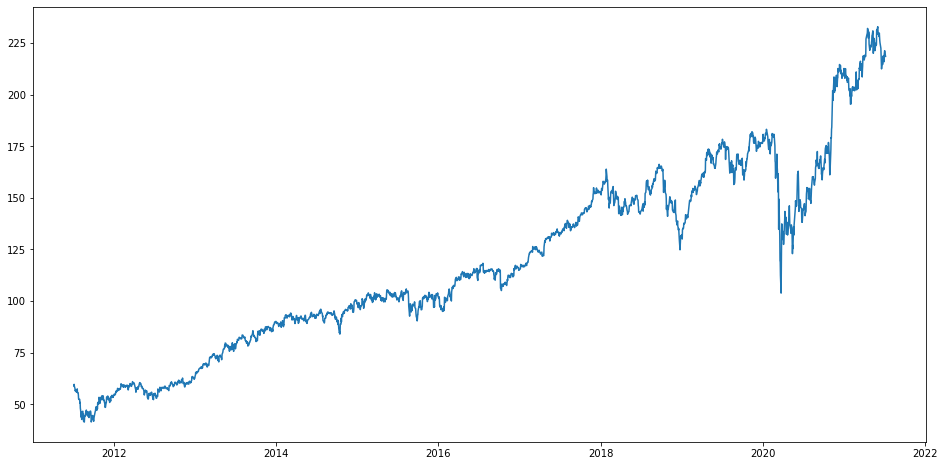

In [10]:
df['Date'] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close/Last"],label='Close Price history')

In [11]:
data = df.sort_index(ascending=True,axis=0)

In [12]:
new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close/Last'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close/Last"][i] = data["Close/Last"][i]

In [13]:
new_dataset = new_dataset.set_index('Date')

In [14]:
new_dataset

,Close/Last
Date,
2011-07-06,58.91
2011-07-07,59.65
2011-07-08,58.76
2011-07-11,57.54
2011-07-12,56.53
...,...
2021-06-29,215.95
2021-06-30,219.35
2021-07-01,220.62


In [15]:
#new_dataset['Close/Last'] = new_dataset['Close/Last'].str.replace('$', '').astype(float)

In [16]:
new_dataset

,Close/Last
Date,
2011-07-06,58.91
2011-07-07,59.65
2011-07-08,58.76
2011-07-11,57.54
2011-07-12,56.53
...,...
2021-06-29,215.95
2021-06-30,219.35
2021-07-01,220.62


In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
final_dataset = new_dataset.to_numpy()

train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]


#new_dataset.drop(["Date"],axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [19]:
inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 3s - loss: 5.3436e-04


In [20]:
X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

In [21]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [22]:
lstm_model.save("saved_model.h5")

In [23]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]

In [24]:
valid_data

,Close/Last
Date,
2015-06-09,102.2
2015-06-10,103.39
2015-06-11,103.52
2015-06-12,102.68
2015-06-15,102.08
...,...
2021-06-29,215.95
2021-06-30,219.35
2021-07-01,220.62


In [25]:
predicted_closing_price

array([[100.3507  ],
       [ 99.7007  ],
       [ 94.72656 ],
       [ 94.6063  ],
       [ 99.38211 ],
       [ 94.03038 ],
       [102.18527 ],
       [109.47131 ],
       [110.17403 ],
       [112.3494  ],
       [110.13889 ],
       [104.9266  ],
       [110.41069 ],
       [113.56895 ],
       [121.38535 ],
       [123.28469 ],
       [128.29353 ],
       [131.15236 ],
       [131.92673 ],
       [138.4758  ],
       [146.26141 ],
       [150.4987  ],
       [143.24307 ],
       [138.57265 ],
       [141.64847 ],
       [148.16327 ],
       [156.20653 ],
       [140.95311 ],
       [128.83344 ],
       [140.97653 ],
       [150.06827 ],
       [161.56868 ],
       [165.09473 ],
       [158.0882  ],
       [158.66081 ],
       [169.29323 ],
       [167.17964 ],
       [168.61769 ],
       [124.977516],
       [127.34953 ],
       [138.64815 ],
       [150.14702 ],
       [156.98543 ],
       [184.09088 ],
       [194.25993 ],
       [189.1282  ],
       [201.7214  ],
       [204.9

In [26]:
#valid_data['Predictions'] = predicted_closing_price

#predicted = pd.DataFrame(predicted_closing_price)

In [27]:
import datetime

In [28]:
# %Y-%m-%d

dates = pd.date_range("2021-07-07", periods=48, freq="D")
dates

DatetimeIndex(['2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23'],
              dtype='datetime64[ns]', freq='D')

In [29]:
predicted = pd.DataFrame(predicted_closing_price, index=dates)
predicted

,0
2021-07-07,100.350700
2021-07-08,99.700699
2021-07-09,94.726562
2021-07-10,94.606300
2021-07-11,99.382111
2021-07-12,94.030380
2021-07-13,102.185272
2021-07-14,109.471313
2021-07-15,110.174026
2021-07-16,112.349403


In [30]:
predicted.rename(columns={0: "Predictions"}, inplace=True)

In [31]:
predicted.head()

,Predictions
2021-07-07,100.350700
2021-07-08,99.700699
2021-07-09,94.726562
2021-07-10,94.606300
2021-07-11,99.382111


In [32]:
final_frames = [valid_data, predicted]

valid_data = pd.concat(final_frames, axis=0, join="outer")
valid_data

,Close/Last,Predictions
2015-06-09,102.2,NaN
2015-06-10,103.39,NaN
2015-06-11,103.52,NaN
2015-06-12,102.68,NaN
2015-06-15,102.08,NaN
...,...,...
2021-08-19,NaN,184.090881
2021-08-20,NaN,194.259933
2021-08-21,NaN,189.128204
2021-08-22,NaN,201.721405


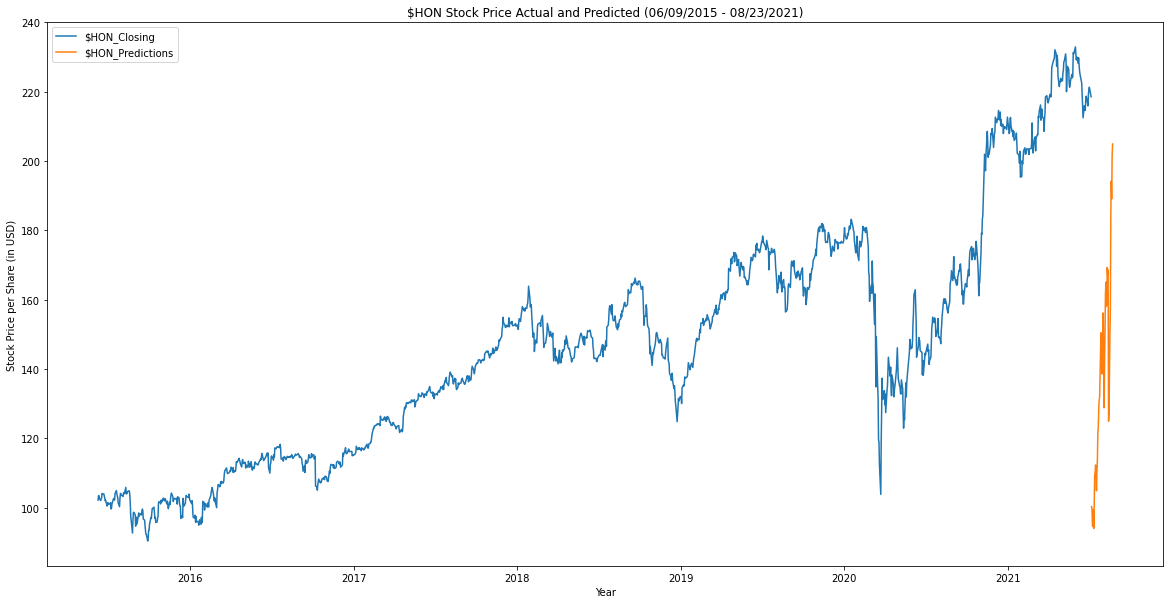

In [33]:
plt.plot(valid_data['Close/Last'], label="$HON_Closing")
plt.plot(valid_data['Predictions'], label="$HON_Predictions")
plt.title('$HON Stock Price Actual and Predicted (06/09/2015 - 08/23/2021)')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc="best")
plt.show()